<a href="https://colab.research.google.com/github/JOTOR/Examples_Python/blob/master/ActiveLearning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning Demo
Created by: Jhonnatan Torres (jhonnatan.torres.suarez@gmail.com)
___

## Background

Let's assume you need to work in a sentiment analysis, you have 1,000 records with a *Positive (1)* or *Negative (0)* labels and around 19,000 without labels, the first option is to increase the number of labeled records, you can do it by yourself or you can hire someone else, but for the sake of this demo, let's say this labeling job is expensive and you cannot afford it.

Another option is to use an Active Learning approach;  using the labeled dataset as basis, train a ML model and try to assign or predict the sentiment of the 19000 unlabeled records, you can use a semi-supervised estimator available in scikit-learn, but for this demo, I will be using  [**modAL**](https://modal-python.readthedocs.io/en/latest/) a python library for Active Learning, the main advantage is you can "help" the model to classify the observations with the **highest uncertainty**, that is right, you can **teach a learner**

In [1]:
!pip install modAL -q

In [2]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import re

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

## Dataset

For this demo I am using a modified version of different reviews and ratings extracted from Trip Advisor and I will be assuming that only 1,000 records (n_initial) have a Positive or Negative label

In [3]:
n_initial = 1000

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/JOTOR/Datasets/main/tripadvisor_hotel_reviews.csv')

In [5]:
df.head(3)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0


In [6]:
df.shape

(20491, 2)

Simple text-processing

In [7]:
df['Review'] = df['Review'].apply(lambda x: re.sub('[^\w\s]',' ',str(x)))
df['Review'] = df['Review'].apply(lambda x: re.sub('[0-9]','',str(x)))
df['Review'] = df['Review'].apply(lambda x: str(x).strip())

In [8]:
df.sample(10)

,Review,Rating
14670,word excellent word worried hotel pick booki...,1
3852,spend couple dollars stayed evening august ...,0
17265,stamp approved friends came visit stayed grea...,0
130,pretty good spent nights moore really like ...,0
14226,loved loved looking forward going stayed rec...,1
7044,does n t better husband just returned second v...,1
8639,great stay jan luyken really close hire bikes ...,1
3426,not bad wife spent honeymoon san juan stayed r...,1
120,good hotel walls liked room small staff great...,1
16860,worst location does say place eat sub place m...,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Creating the initial dataset of 1,000 records to train the model, remaining records are stored in *pool* dataframes

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'])

initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

print(len(X_train))

X_initial, y_initial = X_train.iloc[initial_idx], y_train.iloc[initial_idx]
X_pool, y_pool = np.delete(X_train.values, initial_idx, axis=0), np.delete(y_train.values, initial_idx, axis=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_initial.shape, y_initial.shape)
print(X_pool.shape, y_pool.shape)

15368
(15368,) (5123,) (15368,) (5123,)
(1000,) (1000,)
(14368,) (14368,)


Since I am dealing with text data, I am creating a "preprocessor" to transform the text into vectors and scaling the results with MaxAbsScaler.

The estimator is a SVC with a linear kernel and some regularization

In [11]:
PREPROCESS = make_pipeline(TfidfVectorizer(max_df=0.90, min_df=10, max_features=1500, stop_words='english'),
                           MaxAbsScaler())
ESTIMATOR = SVC(C=0.1, kernel='linear',class_weight='balanced', random_state=1234, probability=True)

In [12]:
learner = ActiveLearner(
    estimator=ESTIMATOR,
    query_strategy=uncertainty_sampling,
    X_training=PREPROCESS.fit_transform(X_initial), y_training=y_initial.values
)

## Active Learning Loop

For this demo I will be using 5 queries, but according to the official documentation, the more queries, the better

In [13]:
n_queries = 5

In [14]:
learner.score(PREPROCESS.transform(X_test), y_test.values)

0.8485262541479602

In [15]:
accuracy_scores = [learner.score(PREPROCESS.transform(X_test), y_test.values)]

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(PREPROCESS.transform(X_pool))
    print("Which sentiment is this?")
    print(X_pool[query_idx])
    #print(query_inst.reshape(1, -1))
    #print(type(query_inst.reshape(1, -1)))
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst, y=y_new)
    #learner.teach(query_inst.reshape(1, -1), y=y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    print(learner.score(PREPROCESS.transform(X_test), y_test.values))
    accuracy_scores.append(learner.score(PREPROCESS.transform(X_test), y_test.values))

Which sentiment is this?
['nice need improvements just came  day trip bali friends  hotel lobby nice staffs nice comments trip   no sign check  staff kinda forgot inform us apparently supossed wait coffee lounge looking swimming pool indian ocean  amazing few   check took  minutes tho hotel n t crowded all   bed pillows comfy    amenities provided disappointing  feel like generic stuffs buy gallons  stayed conrad singapore amazing products   right room bungalow indian ocean nice  totally loving it  inconsistency  day fruits room day dont  day newspaper day dont   hotel service service helpful night asking check closing time restaurant waited  minutes did  called answer customer forgot    positive note tanning pool bar attendants basket filled cold mineral water scented water spray nice cold hand towels  nice   breakfast  good food menu changes  day  felt kinda bored  need flies dining area   spa treatment hotel jiwa spa  great treatment']
1
0.8467694710130783


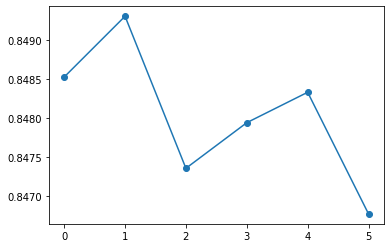

In [20]:
plt.plot(np.arange(n_queries+1), accuracy_scores, marker='o')

Because this is a demo, we have the actual labels to compare with and track the performance of the model, but in the real life, you will be working with unlabeled records, thus to measure the performance of these models can be a little complex, also make sure the data is not so *subjective*. If it is a complicated task for a human, do not expect it is easier for a ML model

## Saving and reusing the model

In [ ]:
import joblib

In [ ]:
joblib.dump(learner, 'ActiveLearner.pkl')

['ActiveLearner.pkl']

In [ ]:
reloaded_al = joblib.load('/content/ActiveLearner.pkl')

In [ ]:
reloaded_al.predict(PREPROCESS.transform(X_test[0:1]))

array([1])

You can save the model as a *pickle* object and reuse it, just like a scikit-learn estimator, just keep in mind you would need to save the text processing pipelines as well in order to use the model in a let's say *deployment* environment

## Teaching the Learner

If you have more labeled examples, you can "teach" them to the model by using the **teach** function

In [ ]:
reloaded_al.teach(PREPROCESS.transform(["worst vacations ever in the worst place ever","best place ever, do not look for another hotel"]), np.array((0,1)))

In [ ]:
reloaded_al.predict(PREPROCESS.transform(['best place ever, do not look for another place']))

array([1])

## Closing Comments

*   At least for this demo and for this particular dataset, increasing the number of initial records to 5000 (25%) increased the time of labeling the queries with the highest uncertainty (Active Learning Loop) to almost 5 minutes.
*   Active Learning can be an interesting approach if you are insterested in reducing the price (in terms or time or money) of labeling jobs
*   The *ActiveLearner* is not so pandas friendly, so you have to think in terms of arrays


## Notes / References

*   **Official Documentation** : https://modal-python.readthedocs.io/en/latest/

*   **Example adapted from** : https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html

*   **modAL library developers/authors**: Tivadar Danka and Peter Horvath; https://github.com/cosmic-cortex/modAL

*   **Dataset authors**: Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223.